In [1]:
# Season-Level Competitiveness in Formula 1

#This notebook analyzes season-level competitiveness in Formula 1 from 1950 to 2025.
#Rather than focusing on individual drivers or constructors, the analysis evaluates
#how competitive each season was by examining how race wins were distributed across
#constructors.

#The goal is to quantify competitive balance and identify periods of dominance
#and parity across Formula 1 history.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

race_data = pd.read_csv("../data/processed/race_data_clean.csv")

In [3]:
race_data.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,fastestLapSpeed,statusId,year,name_x,circuitId,forename,surname,nationality,name_y,grid_position
0,1,18,1,1,22,1,1,1,1,10.0,...,218.3,1,2008,Australian Grand Prix,1,Lewis,Hamilton,British,McLaren,1.0
1,2,18,2,2,3,5,2,2,2,8.0,...,217.586,1,2008,Australian Grand Prix,1,Nick,Heidfeld,German,BMW Sauber,5.0
2,3,18,3,3,7,7,3,3,3,6.0,...,216.719,1,2008,Australian Grand Prix,1,Nico,Rosberg,German,Williams,7.0
3,4,18,4,4,5,11,4,4,4,5.0,...,215.464,1,2008,Australian Grand Prix,1,Fernando,Alonso,Spanish,Renault,12.0
4,5,18,5,1,23,3,5,5,5,4.0,...,218.385,1,2008,Australian Grand Prix,1,Heikki,Kovalainen,Finnish,McLaren,3.0


In [4]:
# Rename columns for clarity
race_data.rename(
    columns={
        'name_y': 'constructor_name',
        'name_x': 'race_name'
    },
    inplace=True
)

# Win indicator
race_data['is_win'] = (race_data['position'] == 1).astype(int)

In [5]:
season_constructor_wins = (
    race_data
    .groupby(['year', 'constructor_name'])
    .agg(wins=('is_win', 'sum'))
    .reset_index()
)

In [6]:
season_totals = (
    race_data
    .groupby('year')
    .agg(total_races=('raceId', 'nunique'))
    .reset_index()
)

In [7]:
season_metrics = season_constructor_wins.merge(
    season_totals, on='year'
)

season_metrics['win_share'] = (
    season_metrics['wins'] / season_metrics['total_races']
)

In [8]:
season_competitiveness = (
    season_metrics
    .groupby('year')
    .agg(
        winning_constructors=('constructor_name', 'nunique'),
        max_win_share=('win_share', 'max')
    )
    .reset_index()
)

In [9]:
#General overview of Constructor Dominance

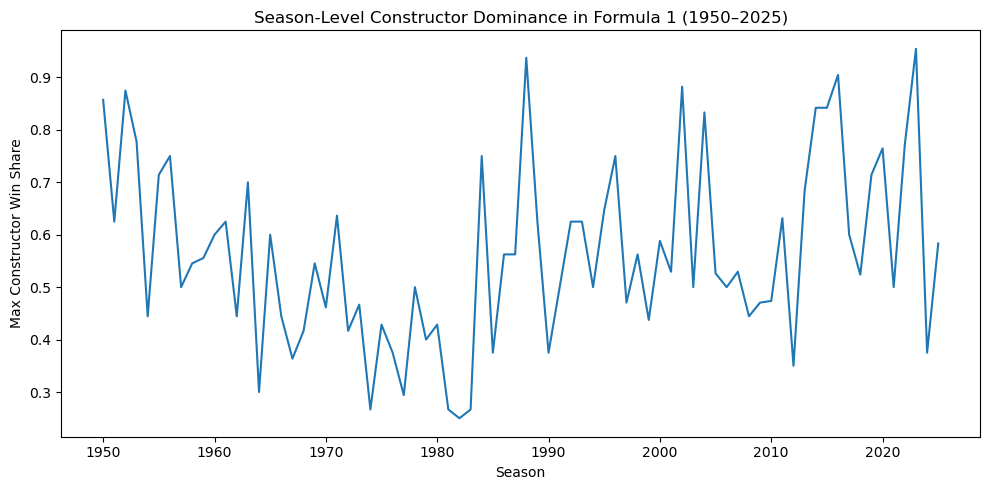

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(
    season_competitiveness['year'],
    season_competitiveness['max_win_share']
)
plt.xlabel("Season")
plt.ylabel("Max Constructor Win Share")
plt.title("Season-Level Constructor Dominance in Formula 1 (1950–2025)")

plt.tight_layout()
plt.savefig(
    "../figures/figure_05_1_season_dominance.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

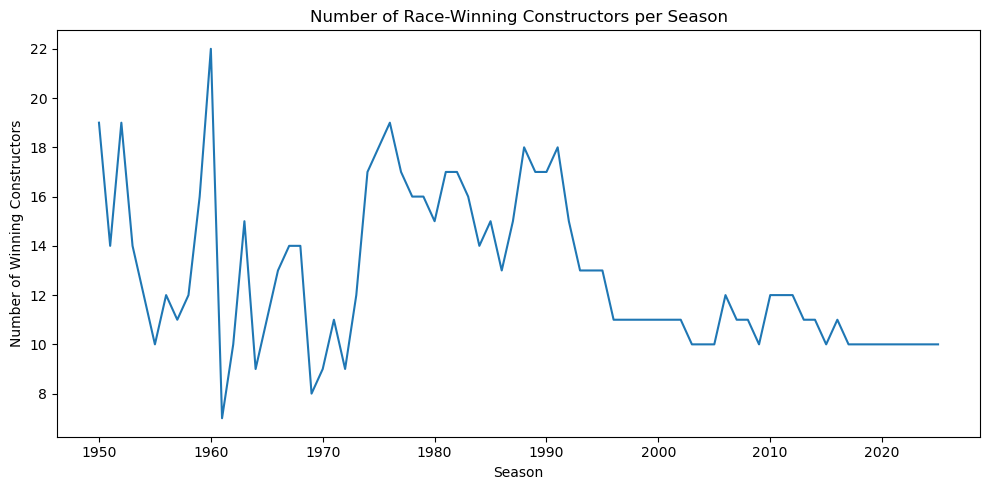

In [11]:
plt.figure(figsize=(10,5))
plt.plot(
    season_competitiveness['year'],
    season_competitiveness['winning_constructors']
)
plt.xlabel("Season")
plt.ylabel("Number of Winning Constructors")
plt.title("Number of Race-Winning Constructors per Season")

plt.tight_layout()
plt.savefig(
    "../figures/figure_05_2_winning_constructors.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

In [12]:
#Constructive Dominance over the eras

In [13]:
def era_label(year):
    if year < 1970:
        return "Early Era (1950–1969)"
    elif year < 1990:
        return "Turbo / Transition Era (1970–1989)"
    elif year < 2010:
        return "Refuelling Era (1990–2009)"
    elif year < 2022:
        return "Hybrid Era (2010–2021)"
    else:
        return "Ground Effect Era (2022–2025)"

race_data['era'] = race_data['year'].apply(era_label)

In [14]:
race_data[['year', 'era']].drop_duplicates().head(10)

,year,era
0,2008,Refuelling Era (1990–2009)
287,2007,Refuelling Era (1990–2009)
568,2006,Refuelling Era (1990–2009)
842,2005,Refuelling Era (1990–2009)
1121,2004,Refuelling Era (1990–2009)
1382,2003,Refuelling Era (1990–2009)
1594,2002,Refuelling Era (1990–2009)
1806,2001,Refuelling Era (1990–2009)
2032,2000,Refuelling Era (1990–2009)
2262,1999,Refuelling Era (1990–2009)


In [15]:
season_competitiveness = season_competitiveness.merge(
    race_data[['year', 'era']].drop_duplicates(),
    on='year'
)

In [16]:
season_competitiveness.head()

,year,winning_constructors,max_win_share,era
0,1950,19,0.857143,Early Era (1950–1969)
1,1951,14,0.625000,Early Era (1950–1969)
2,1952,19,0.875000,Early Era (1950–1969)
3,1953,14,0.777778,Early Era (1950–1969)
4,1954,12,0.444444,Early Era (1950–1969)


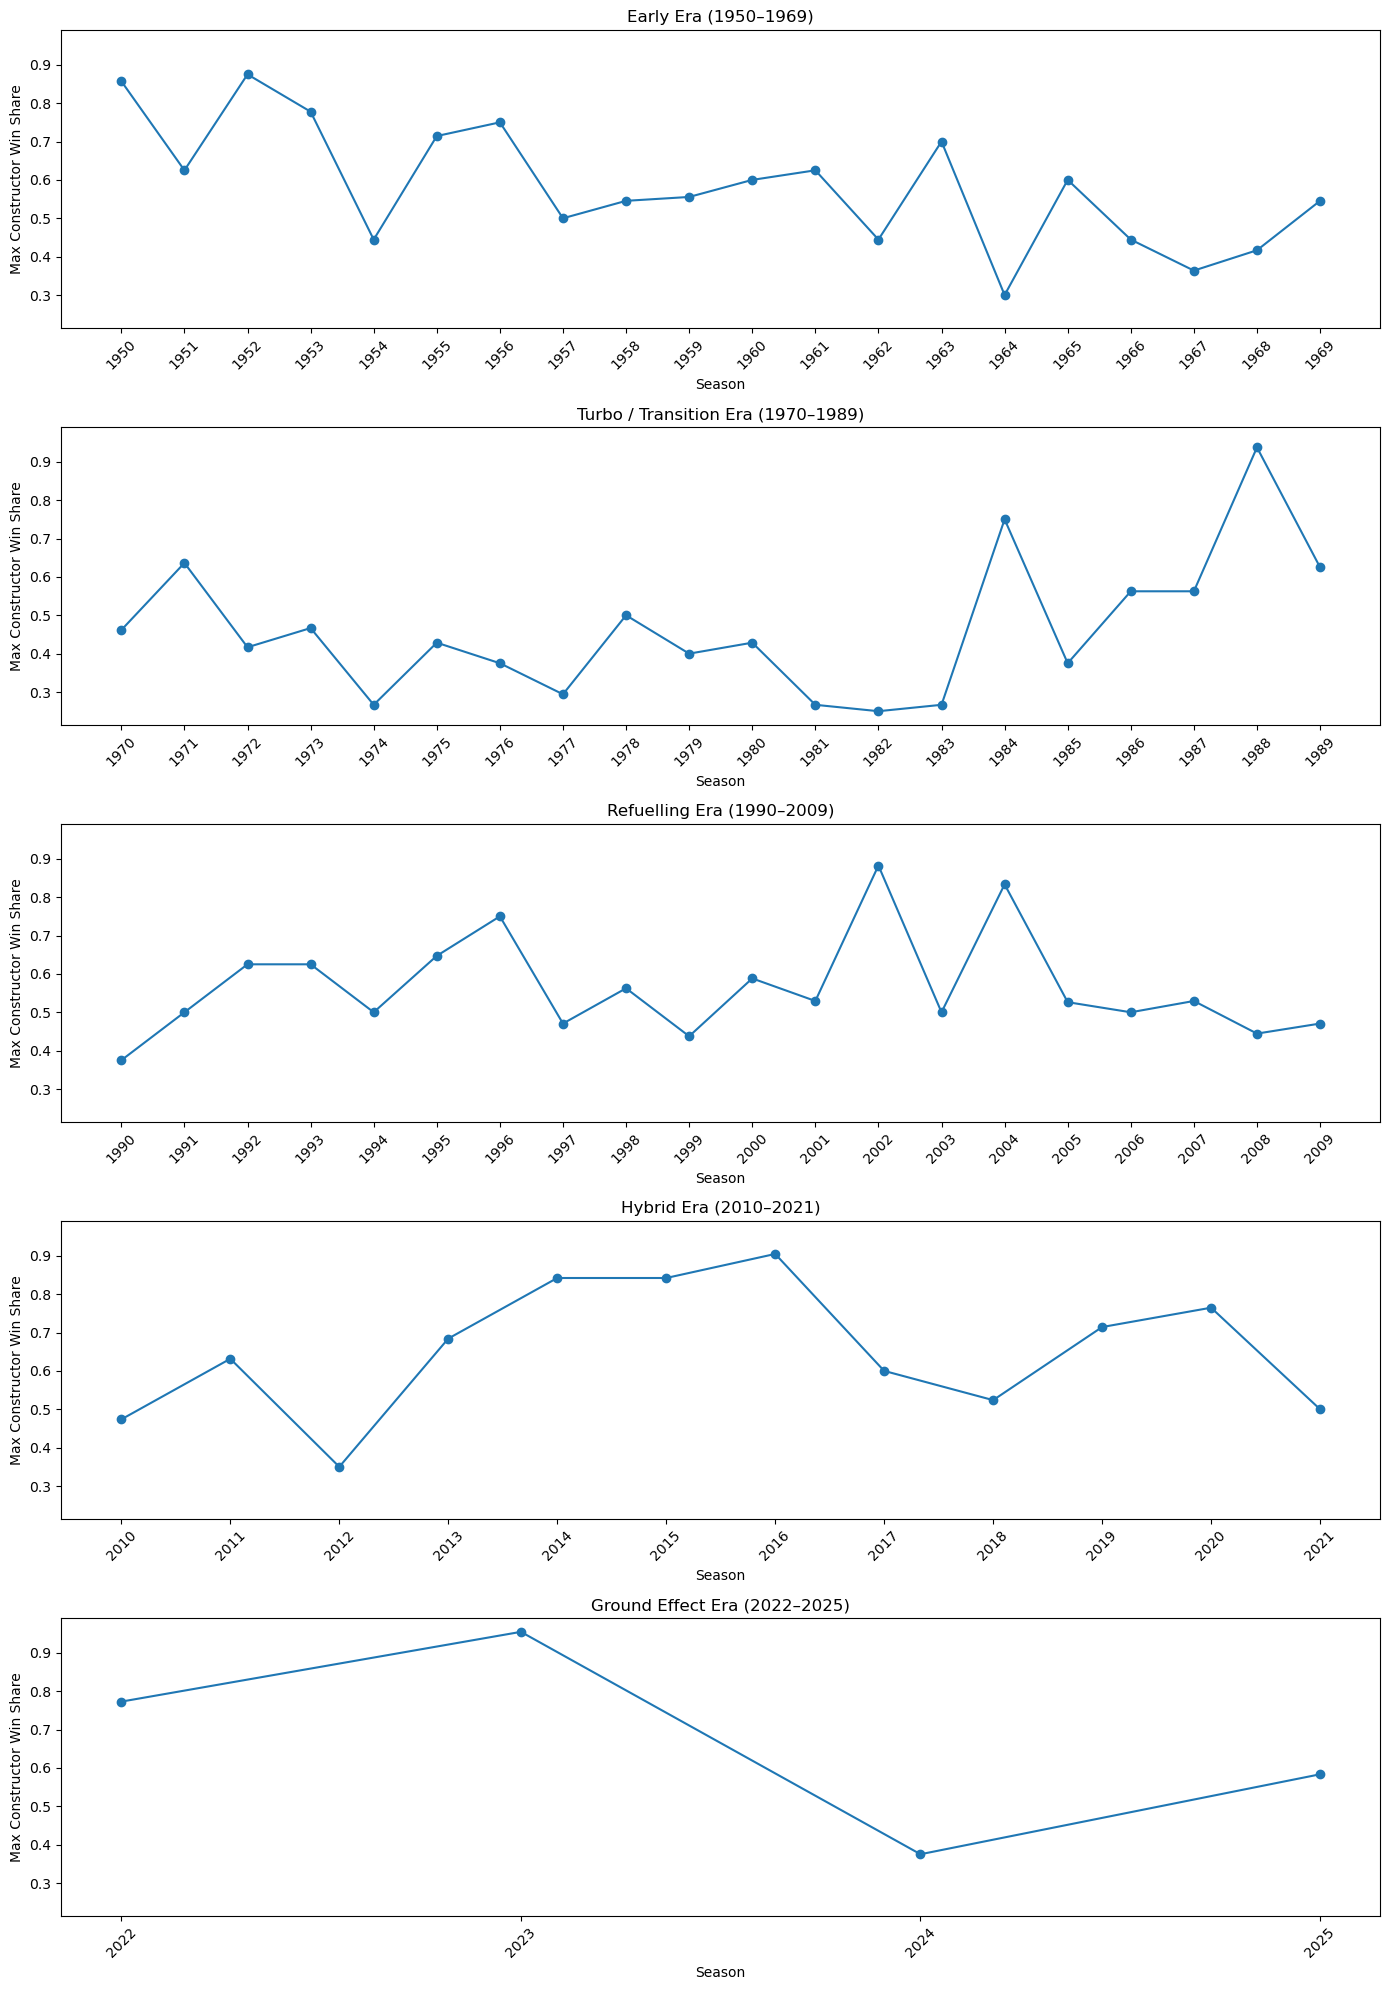

In [17]:
import matplotlib.pyplot as plt

eras = season_competitiveness['era'].unique()

fig, axes = plt.subplots(
    len(eras), 1,
    figsize=(14, 4 * len(eras)),
    sharey=True
)

for ax, era in zip(axes, eras):
    data = season_competitiveness[
        season_competitiveness['era'] == era
    ]

    ax.plot(
        data['year'],
        data['max_win_share'],
        marker='o'
    )

    ax.set_title(era)
    ax.set_xlabel("Season")
    ax.set_ylabel("Max Constructor Win Share")

    years = data['year'].astype(int).tolist()
    ax.set_xticks(years)
    ax.set_xticklabels(years, rotation=45)

plt.tight_layout()
plt.savefig(
    "../figures/figure_05_3_era_based_dominance.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

In [18]:
era_summary = (
    season_competitiveness
    .groupby('era')
    .agg(
        avg_max_win_share=('max_win_share', 'mean'),
        peak_max_win_share=('max_win_share', 'max'),
        seasons=('year', 'count')
    )
    .reset_index()
)

era_summary

,era,avg_max_win_share,peak_max_win_share,seasons
0,Early Era (1950–1969),0.584215,0.875000,20
1,Ground Effect Era (2022–2025),0.671402,0.954545,4
2,Hybrid Era (2010–2021),0.652604,0.904762,12
3,Refuelling Era (1990–2009),0.564837,0.882353,20
4,Turbo / Transition Era (1970–1989),0.463500,0.937500,20


In [19]:
era_summary.to_csv(
    "../data/processed/era_summary.csv",
    index=False
)

In [ ]:
### Era-Based Season Dominance Analyzing season-level constructor dominance 
#within regulation-defined eras reveals clear differences in competitive balance across Formula 1 history.
#Earlier eras exhibit lower average dominance with greater variability, while
#modern eras—particularly the Hybrid era—show sustained high concentration of
#race victories by a single constructor.

#This supports the hypothesis that increased technical complexity and regulatory
#stability enable long-term dominance, whereas frequent regulation changes
#temporarily reduce competitive imbalance.

In [ ]:
### Notes on Interpretation

#The dominance metrics presented here are descriptive and do not imply causal
#relationships. Variations in season-level dominance may coincide with regulatory,
#technological, or organizational factors, but no direct causal attribution is
#made in this analysis. Early seasons should also be interpreted with caution due
#to smaller race calendars.
# Further statistical analysis would be required to establish causality.